# Predictive Analysis with different approaches - Julien Heiduk

In [3]:
## https://www.kaggle.com/code/zoupet/predictive-analysis-with-different-approaches

Import + Cleaning

In [5]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For machine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv("/Users/elena/Downloads/train_1.csv")

In [7]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [8]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [9]:
train_flattened.reset_index(drop=False,inplace=True)
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-12,13.0,1.0,26.12,18.0,5,2016,11,12
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-12,12.0,1.0,34.12,19.0,5,2016,11,12
2,3C_zh.wikipedia.org_all-access_spider,2016-11-12,6.0,1.0,8.44,4.0,5,2016,11,12
3,4minute_zh.wikipedia.org_all-access_spider,2016-11-12,38.0,1.0,16.04,14.0,5,2016,11,12
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-11-12,13.0,1.0,16.04,10.0,5,2016,11,12


Aggregation & Visualization

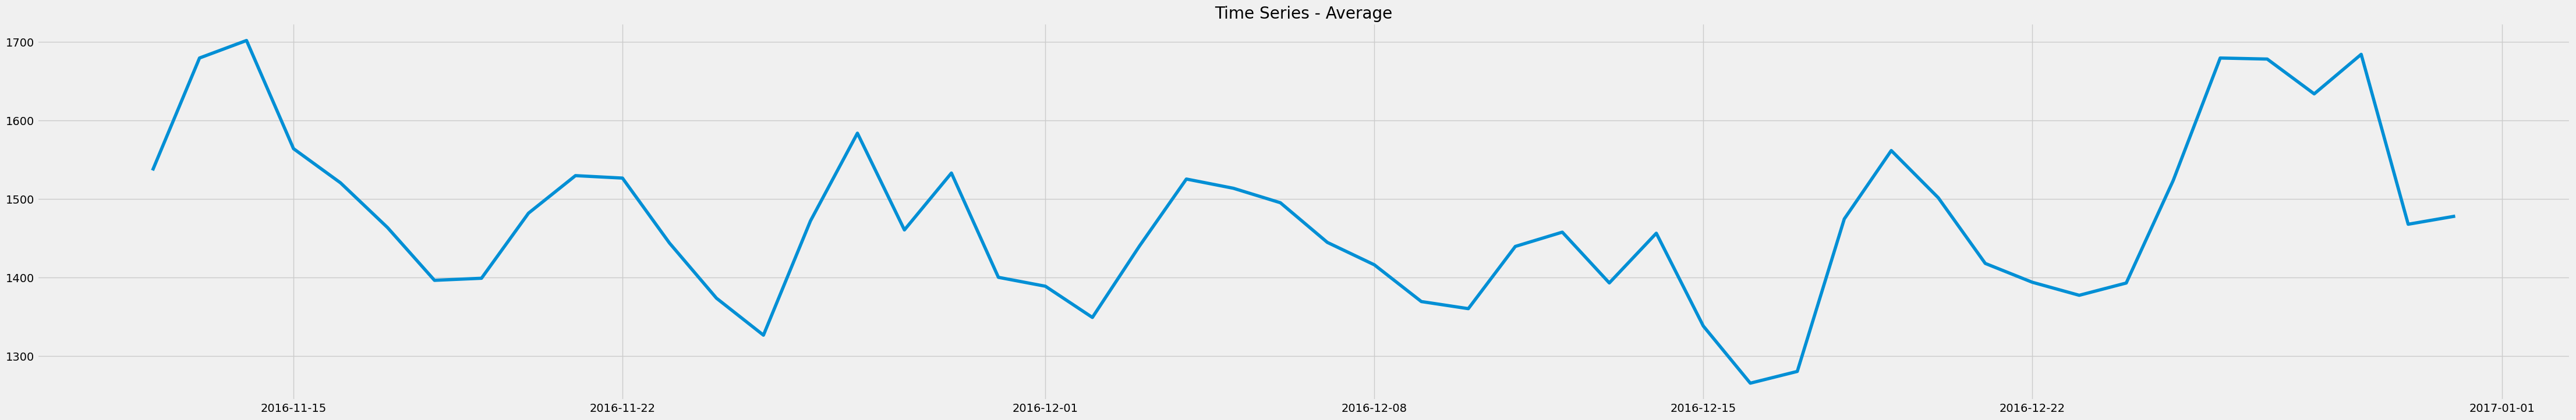

In [11]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

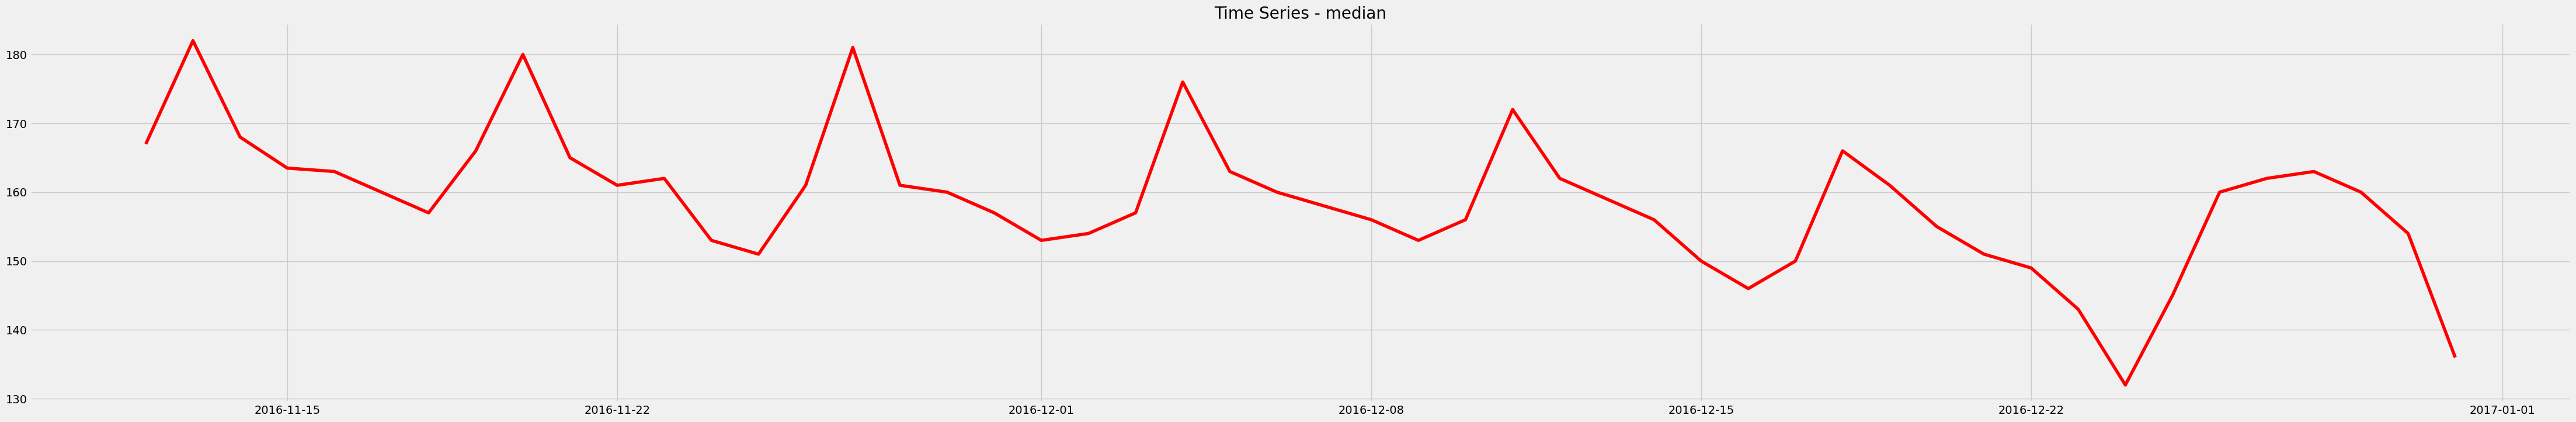

In [12]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

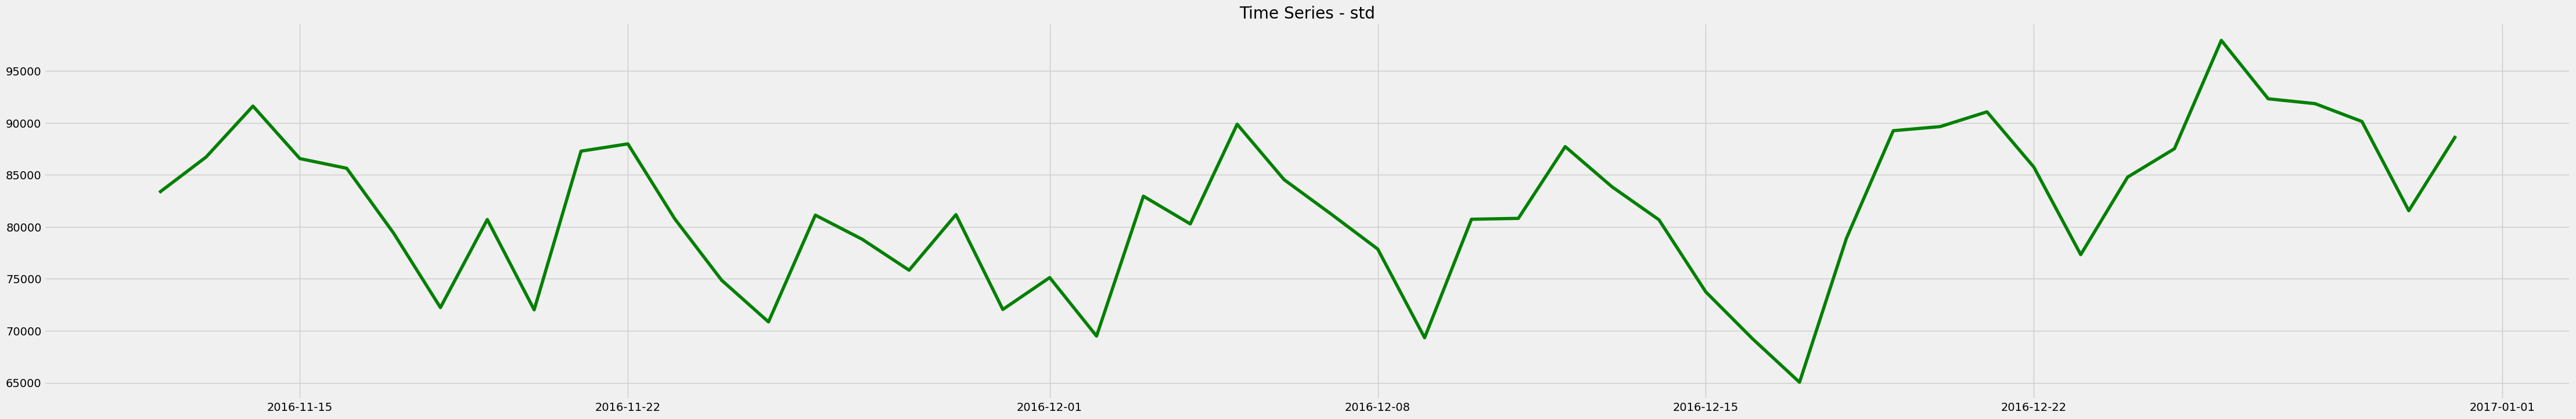

In [13]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [14]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

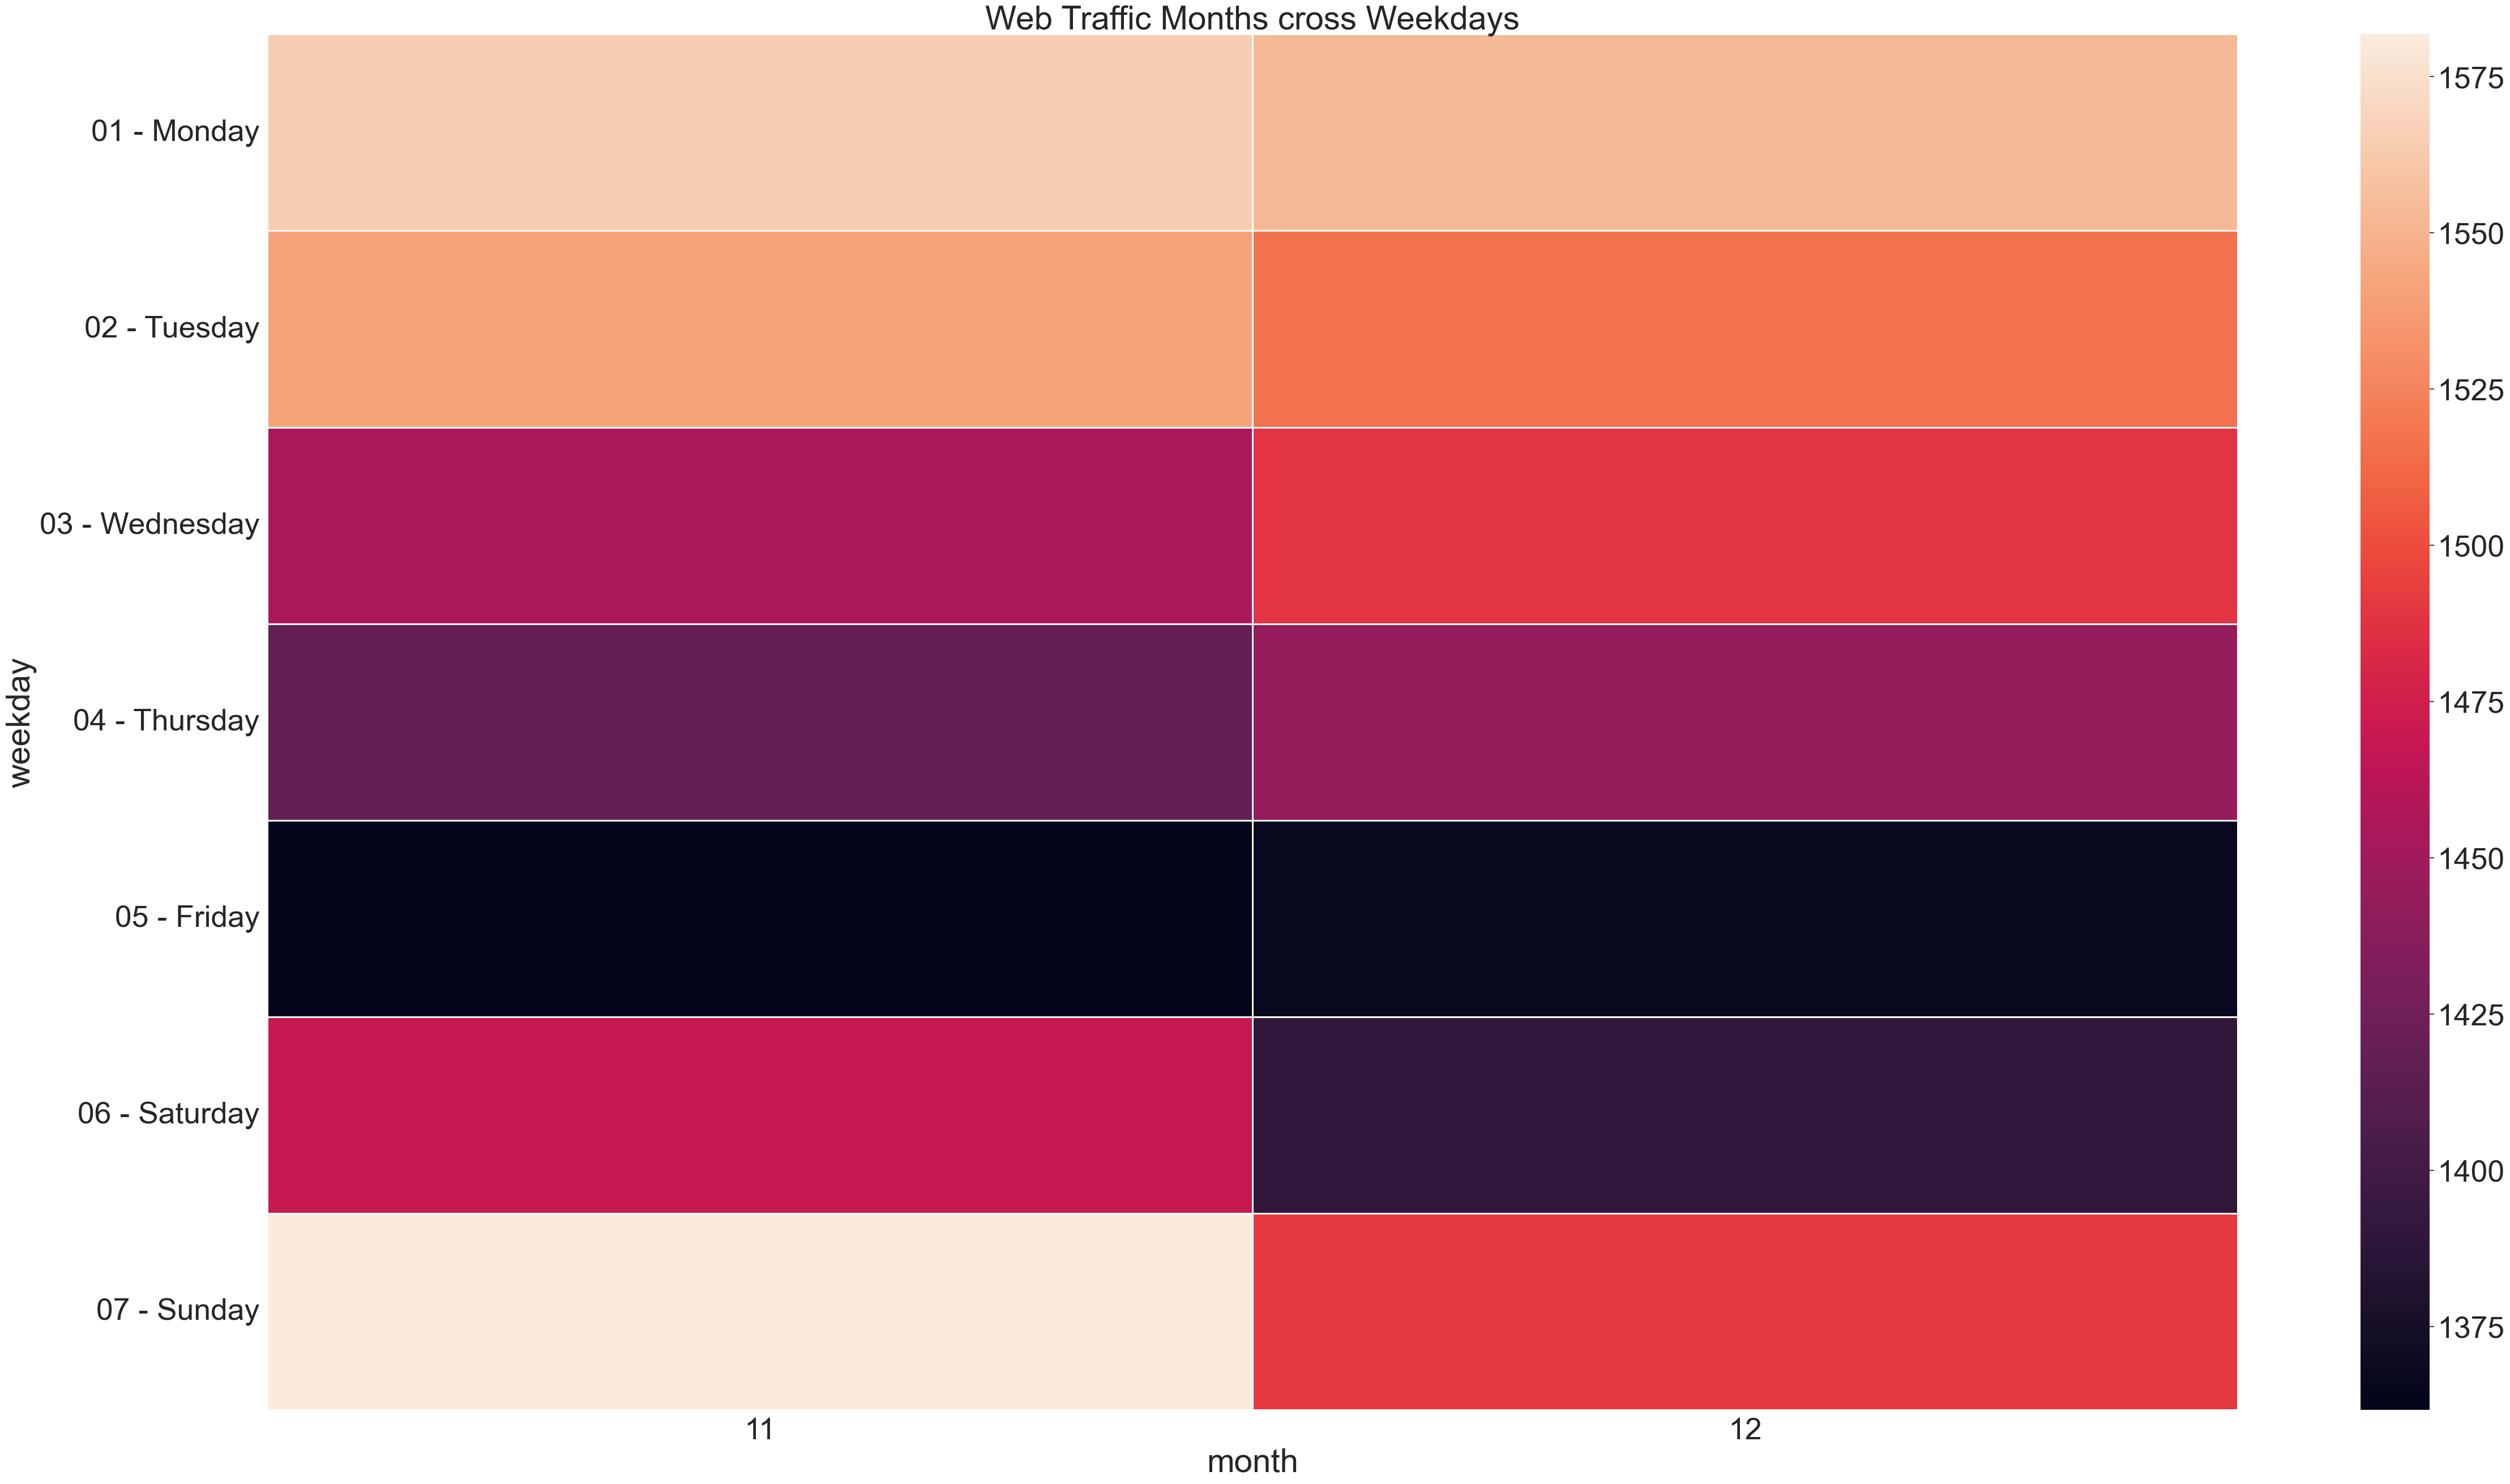

In [15]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot(index='weekday', columns='month', values='Visits')
train_group.sort_index(inplace=True)

sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

This heatmap show us in average the web traffic by weekdays cross the months. In our data we can see there are less activity in Friday and Saturday for December and November. And the biggest traffic is on the period Monday - Wednesday.

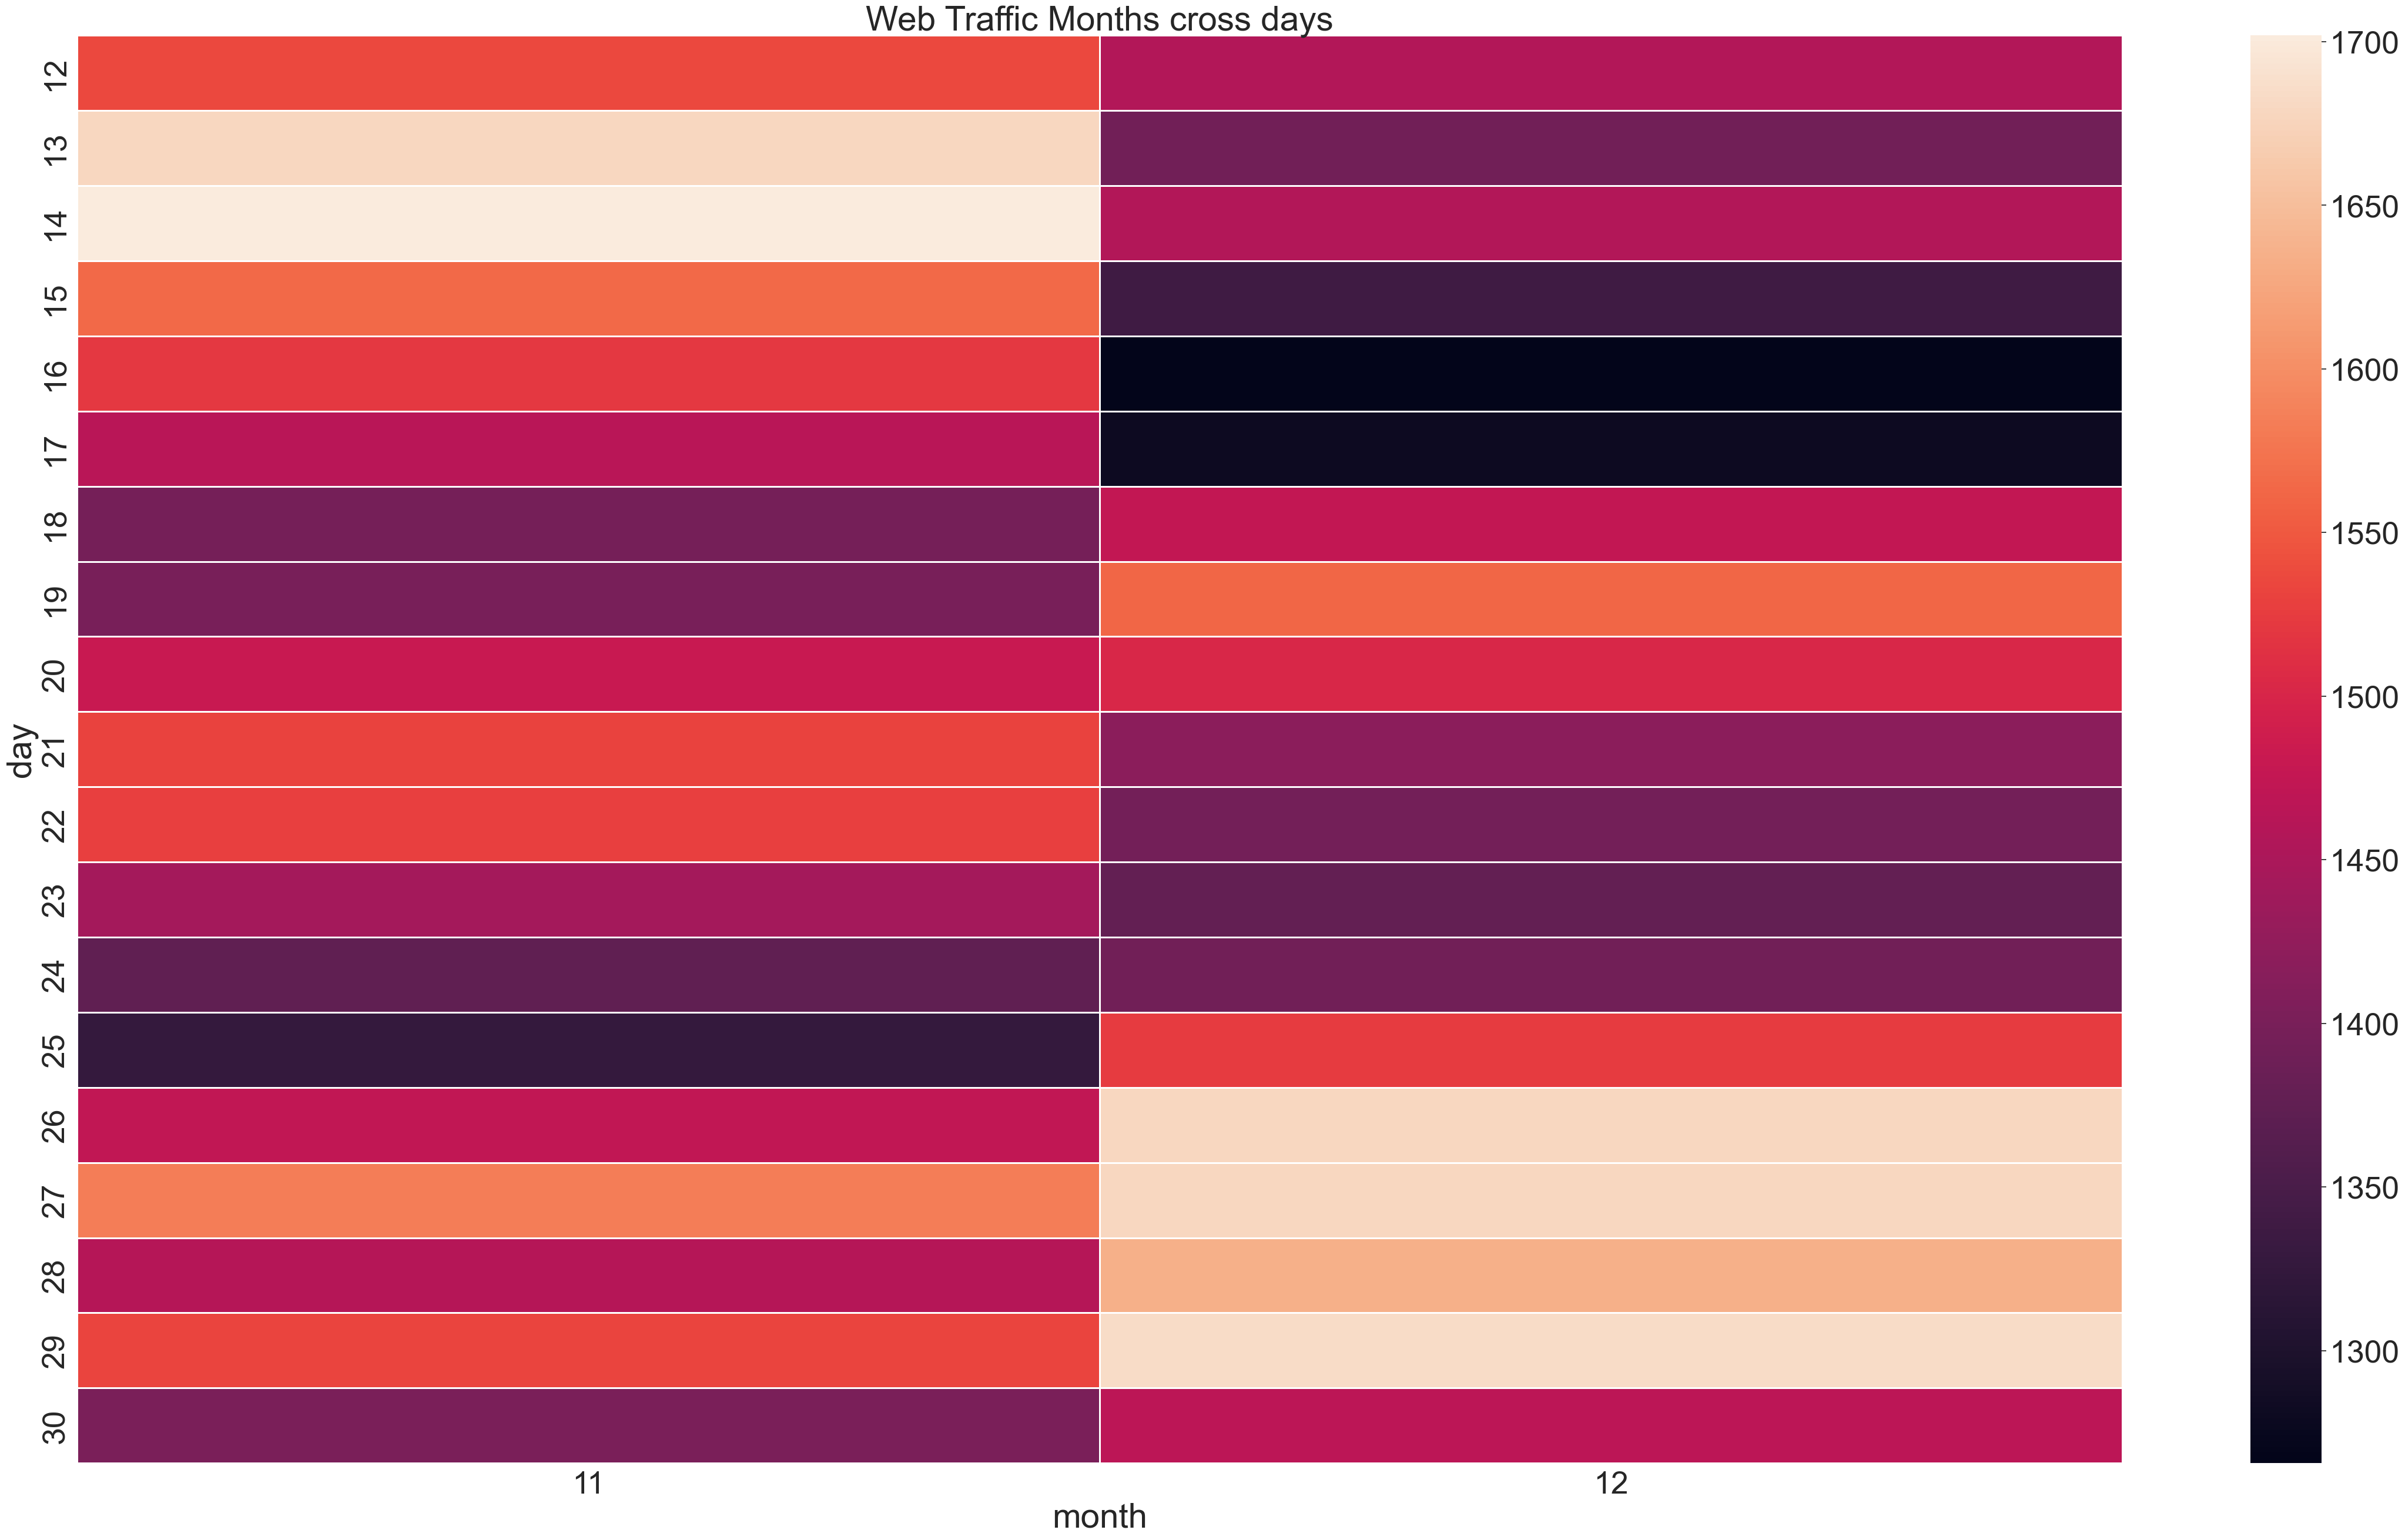

In [17]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot(index='day', columns='month',values='Visits')

train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

With this graph it is possible to see they are two periods with a bigger activity than the rest. The two periods are 25-29 December and 13-14 November. And we can see one period with little activity 15-17 December. They are maybe a few outliers during these two periods.

AdaBoostRegressor

In [20]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year', 'month', 'day']] = times_series_means['Date_str'].str.split('-', expand=True)
date_staging = times_series_means['day'].str.split(' ', n=2, expand=True)
date_staging.columns = ['day', 'other']
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()

,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16


In [21]:
from statsmodels.tsa.stattools import lagmat 

# Reset the index
times_series_means.reset_index(drop=True, inplace=True)

def lag_func(data, lag):
    X = lagmat(data["diff"], maxlag=lag)
    lagged = data.copy()
    for c in range(1, lag + 1):
        lagged[f'lag{c}'] = X[:, c - 1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data["diff"].iloc[1:] = data.iloc[1:, 1].values - data.iloc[:-1, 1].values
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count, lag)
last_date = lagged['date'].max()

In [22]:
lagged.head()

,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,1536.471757,5,2016,11,12,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2016-11-13,1679.630589,6,2016,11,13,143.158833,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2016-11-14,1701.941831,0,2016,11,14,22.311241,143.158833,NaN,0.000000,0.0,0.0,0.0,0.0
3,2016-11-15,1564.172228,1,2016,11,15,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0,0.0
4,2016-11-16,1520.673959,2,2016,11,16,-43.498270,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0


In [23]:
# Train Test split
def train_test(data_lag):
    xc = [f'lag{i}' for i in range(1, lag + 1)] + ['weekday', 'day']
    split = 0.70
    xt = data_lag.iloc[(lag + 1):][xc]
    yt = data_lag.iloc[(lag + 1):]["diff"]
    isplit = int(len(xt) * split)
    
    x_train, y_train = xt.iloc[:isplit], yt.iloc[:isplit]
    x_test, y_test = xt.iloc[isplit:], yt.iloc[isplit:]
    
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [24]:
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Fit the first model and make predictions
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts, prediction)  # Use prediction directly
    mae = mean_absolute_error(y_ts, prediction)  # Use prediction directly

    print("-----------------------------------------------")
    print(f"MAE with 70% of the data to train: {mae:.4f}")  # Formatting for better readability
    print("-----------------------------------------------")

    # Fit the second model with all data
    model1.fit(xt, yt)
    
    return model1, prediction, model0

model0 = AdaBoostRegressor(n_estimators=5000, random_state=42, learning_rate=0.01)
model1 = AdaBoostRegressor(n_estimators=5000, random_state=42, learning_rate=0.01)

clr, prediction, clr0 = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
MAE with 70% of the data to train: 76.9265
-----------------------------------------------


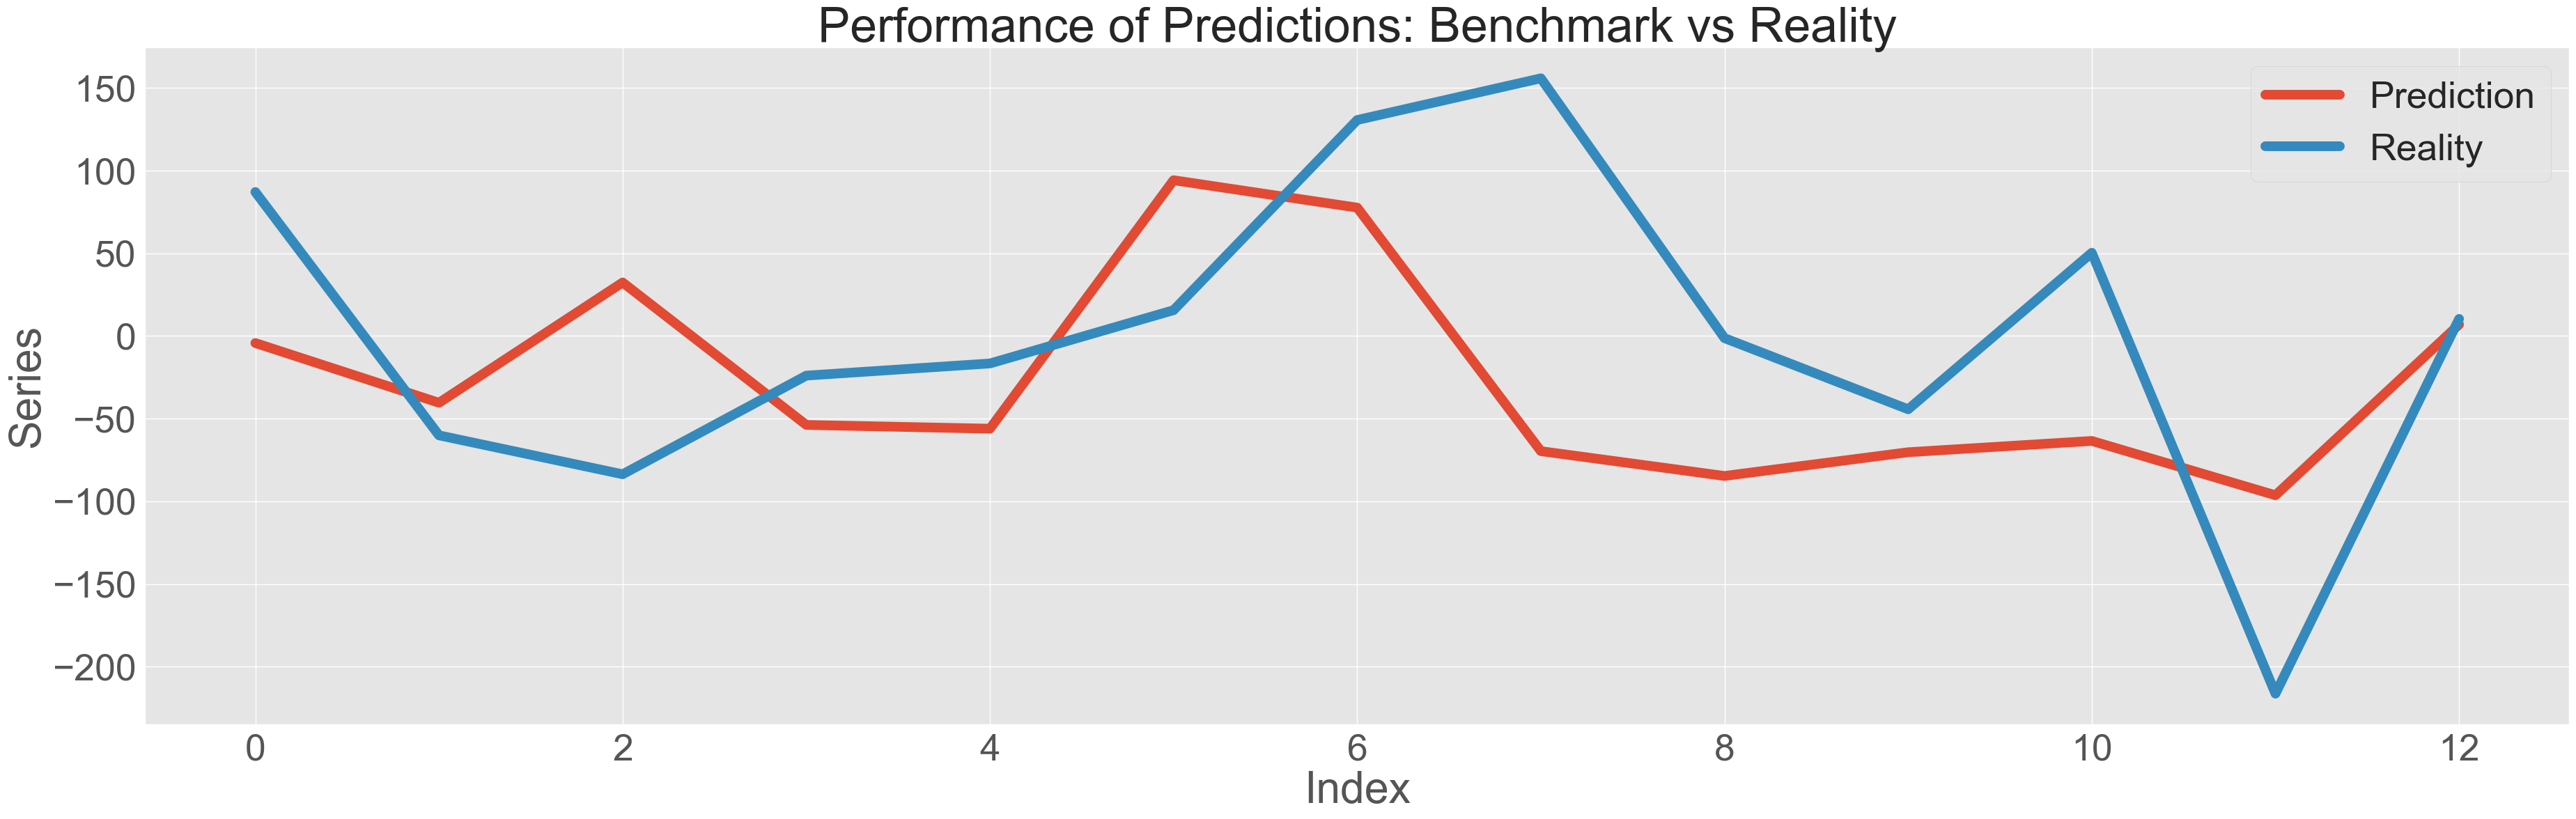

In [25]:
# Performance 1
plt.style.use('ggplot')
plt.figure(figsize=(40, 12))
plt.plot(prediction, label='Prediction', linewidth=10)
plt.plot(y_test.values, label='Reality', linewidth=10)  # Using .values for clarity
plt.ylabel('Series', fontsize=45)
plt.legend()
plt.title('Performance of Predictions: Benchmark vs Reality', fontsize=50)
plt.xlabel('Index', fontsize=45)  # Added x-axis label for clarity
plt.grid(True)
plt.show()

In [26]:
# Prediction
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

In [27]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)
    
    for i in range(number_of_days - 1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x: x.weekday())
        weekday = data_pred['weekday'][0]
        
        row = pd.Series([lag1, lag2, lag3, lag4, lag5, lag6, lag7, lag8, weekday],
                        index=xtrain.columns) 
        
        to_predict = pd.DataFrame([row])
        
        prediction = pd.DataFrame(model.predict(to_predict), columns=['diff'])
        
        if i == 0:
            last_predict = data_lag["Visits"].iloc[-1] + prediction.values[0][0]
        else:
            last_predict = data_lag["Visits"].iloc[-1] + prediction.values[0][0]
        
        new_row = pd.DataFrame({
            'lag1': [lag1],
            'lag2': [lag2],
            'lag3': [lag3],
            'lag4': [lag4],
            'lag5': [lag5],
            'lag6': [lag6],
            'lag7': [lag7],
            'lag8': [lag8],
            'weekday': [weekday], 
            'diff': prediction.values[0][0],
            'Visits': [last_predict],
            'date': data_pred["date"].iloc[0]
        })
        
        data_lag = pd.concat([data_lag, new_row], ignore_index=True)
        
        data_pred = data_pred[data_pred["date"] > data_pred["date"].iloc[0]].reset_index(drop=True)
        
    return data_lag

In [28]:
model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [29]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

In [30]:
lagged[lagged['diff']<0]
lagged.loc[lagged['Visits'] < 0, 'Visits'] = 0

In [31]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
# df_pred = data_to_pred.drop_duplicates(subset='date', keep='first') for duplicates

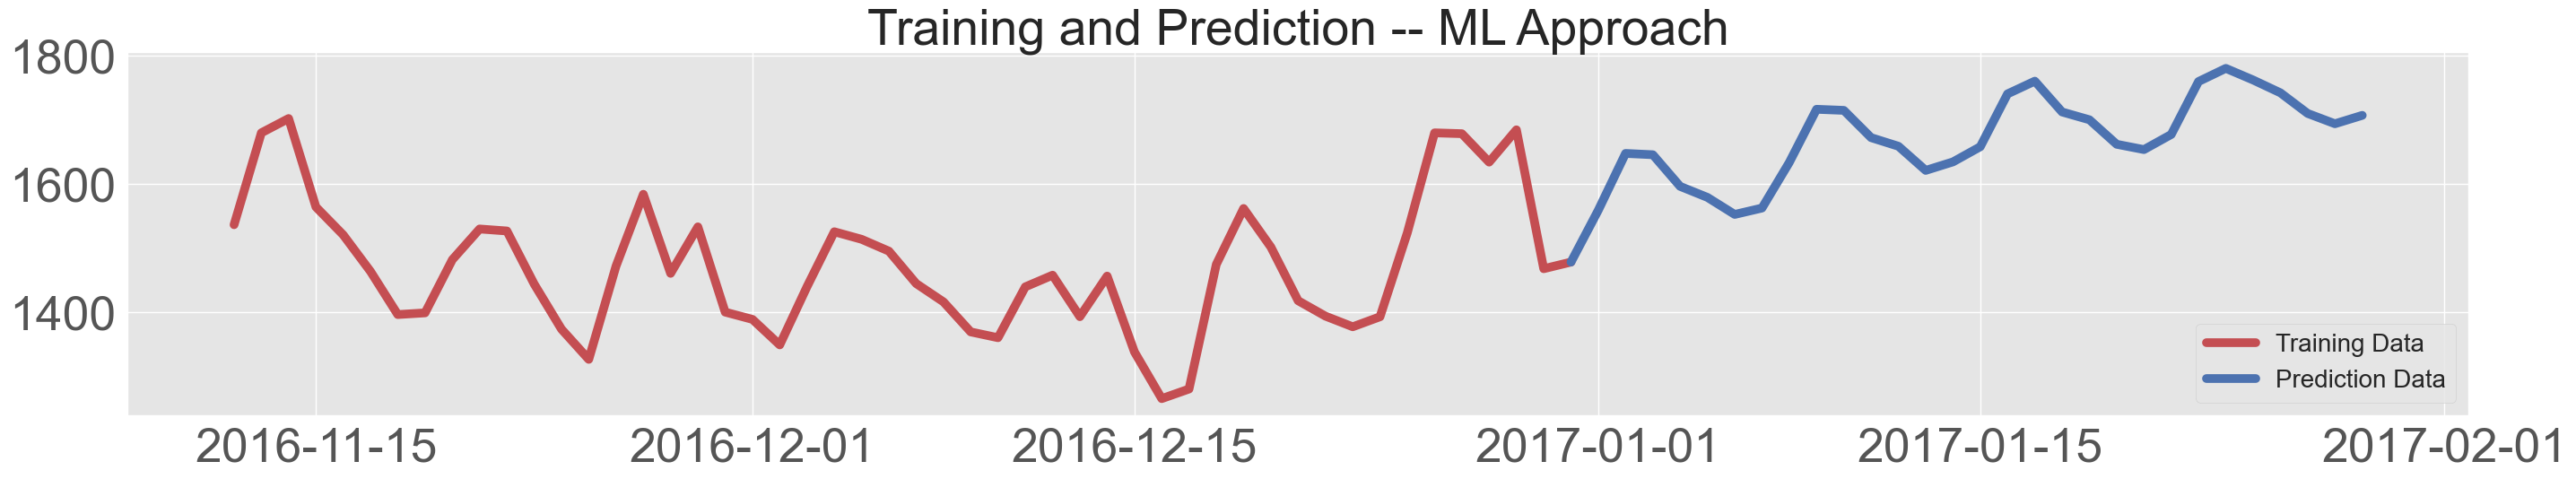

In [32]:
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))

plt.plot(df_train.date, df_train.Visits, color='r', label='Training Data', linewidth=7)
plt.plot(df_pred.date, df_pred.Visits, color='b', label='Prediction Data', linewidth=7)

plt.title('Training and Prediction -- ML Approach', fontsize=40)
plt.legend(loc='lower right', fontsize=20)

plt.show()

Basic Approach: We will use a simple model with the average of the activity by weekdays.

In [34]:
lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr   = lagged_basic[lagged_basic['date'] < last_date]
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]
lagged_basic_pred.drop('Visits',inplace=True,axis=1)

In [35]:
prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days

,weekday,Visits
0,0,1615.388748
1,1,1599.357248
2,2,1550.985798
3,3,1521.759965
4,4,1463.477106
5,5,1492.018091
6,6,1578.634670


In [36]:
basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')
basic_approach = pd.concat([lagged_basic_tr,basic_pred])

In [37]:
plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits)

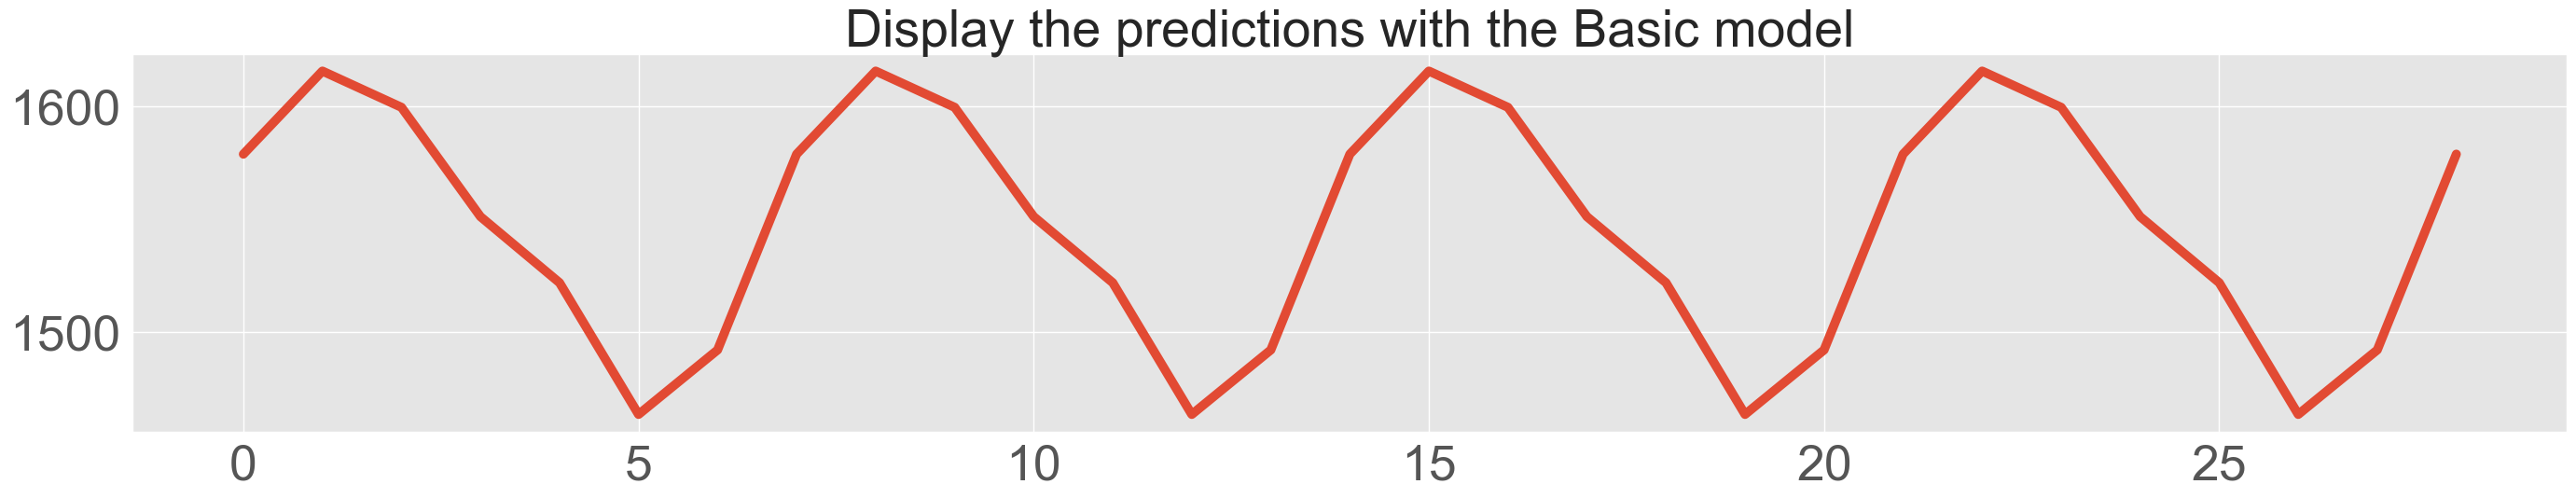

In [38]:
plt.figure(figsize=(30, 5))
plt.plot(plot_basic, linewidth=7)
plt.title('Display the predictions with the Basic model', fontsize=40)
plt.show()

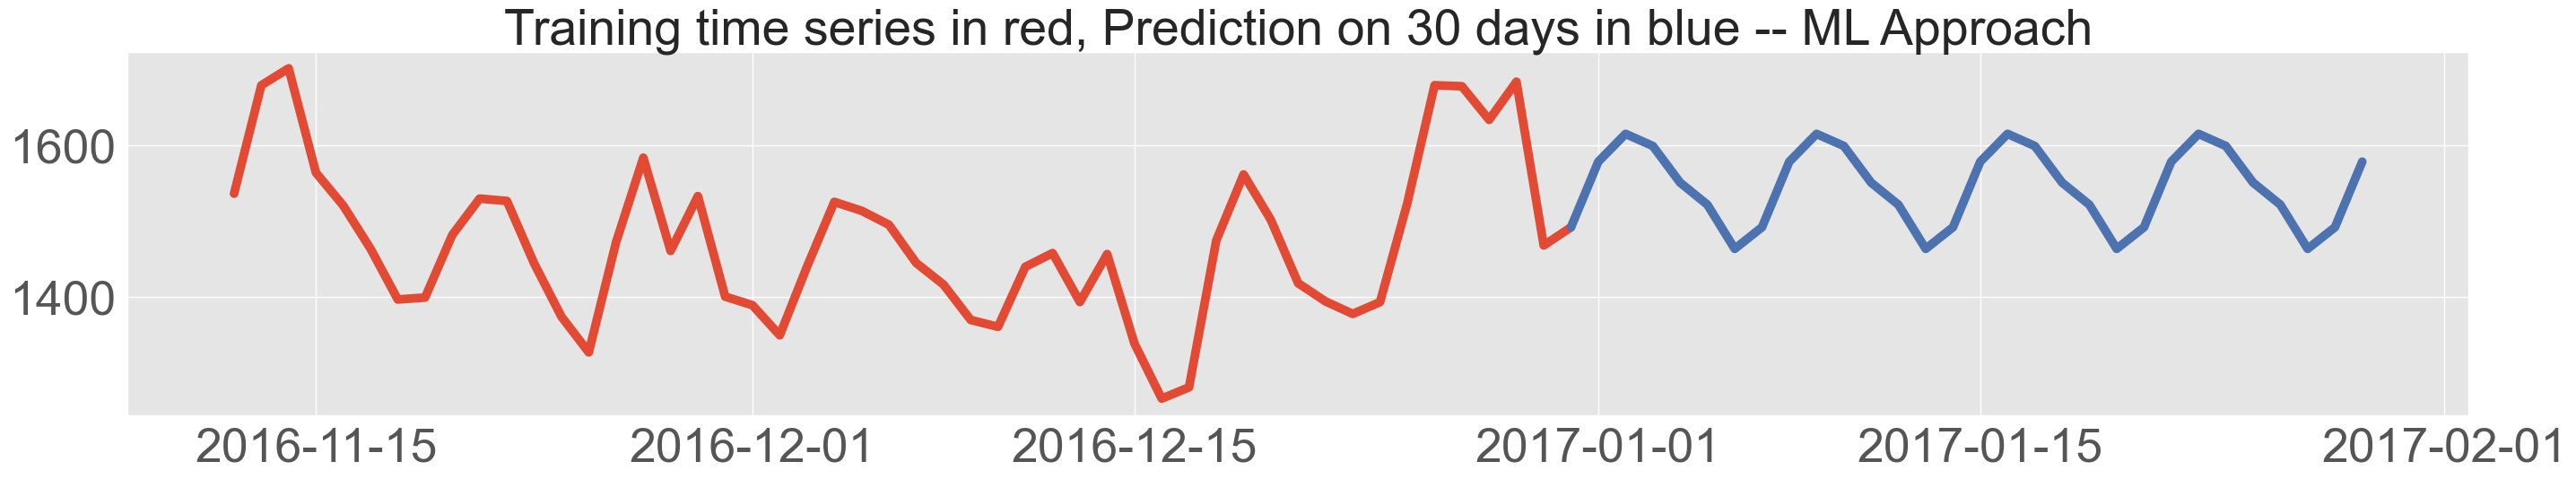

In [39]:
df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits, linewidth=7)
plt.plot(df_pred.date,df_pred.Visits,color='b', linewidth=7)
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach', fontsize=40)
plt.show()

No optimisation ! No choice between linear, Bagging, boosting or others ! Just with an average by week days and we have a result ! Fast and easily !

PROPHET

Forecasting tool available in Python & R. We will forecast and display the trend of activity on the period and for a week.

13:39:50 - cmdstanpy - INFO - Chain [1] start processing
13:39:50 - cmdstanpy - INFO - Chain [1] done processing


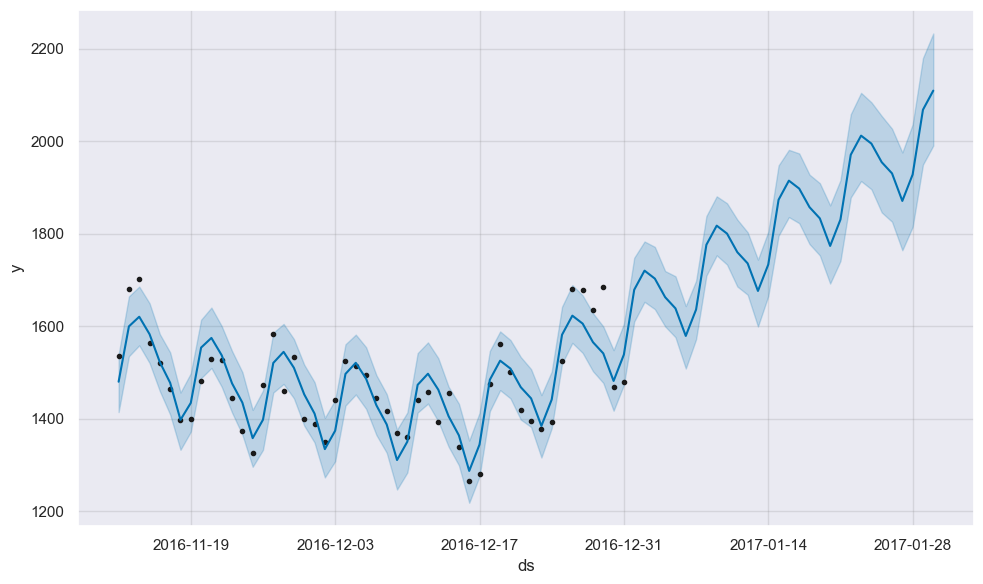

In [43]:
from prophet import Prophet
sns.set(font_scale=1) 
df_date_index = times_series_means[['date','Visits']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

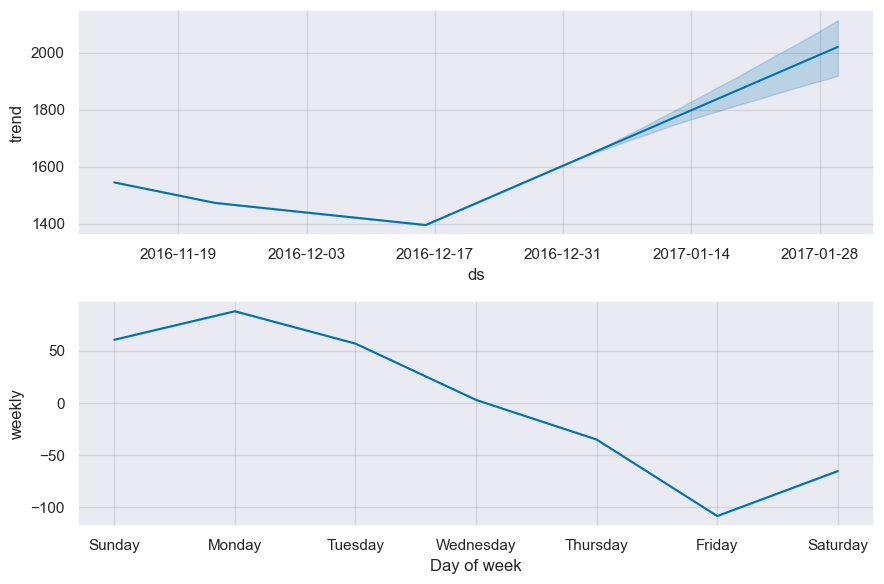

In [44]:
m.plot_components(forecast);

KERAS STARTER

In this part we will use Keras without optimisation to forecast. It is just a very simple code to begin with Keras and a Time Series. For our example we will try just with one layer and 8 Neurons.

In [47]:
df_dl = times_series_means[['date','Visits']]

train_size = int(len(df_dl) * 0.80)
test_size = len(df_dl) - train_size
train, test = df_dl.iloc[0:train_size,:], df_dl.iloc[train_size:len(df_dl),:]
print(len(train), len(test))

40 10


In [48]:
look_back = 1

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1].values[0]
        b = dataset.iloc[i+look_back, 1]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [50]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [51]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=2, verbose=0)

In [90]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore, trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (testScore, testScore))

Train Score: 66.01 MSE (66.01 MAE)
Test Score: 82.98 MSE (82.98 MAE)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


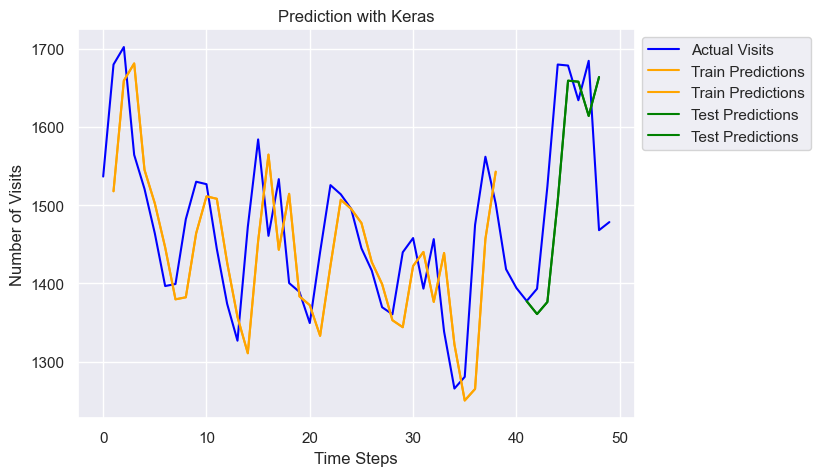

In [106]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(df_dl)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df_dl)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(df_dl) - 1, :] = testPredict

plt.clf()

# Plot baseline and predictions with unique labels
plt.plot(np.array(df_dl.Visits), label='Actual Visits', color='blue')
plt.plot(trainPredictPlot, label='Train Predictions', color='orange')
plt.plot(testPredictPlot, label='Test Predictions', color='green')

plt.title('Prediction with Keras')
plt.xlabel('Time Steps')
plt.ylabel('Number of Visits')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# 